In [1]:
import os
import jax
import numpy as np
jax.devices()

[CpuDevice(id=0)]

In [2]:
os.chdir("../../..")
from scripts.nj.neurosci import *
import scripts.nj.graph_to_arrays as ga

## Получаем данные

In [3]:
res = ga.load_jax_context("Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz")

Загрузка контекста из: Datasets/Generated/jax/2025d5/test_graph_20n_optimized_params.npz
   Загружено: 2 групп, 3 массивов ребер, 0 массивов признаков.
Контекст симуляции успешно собран из загруженных данных.


In [4]:
stom = jnp.array(res['stom'])

In [5]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

In [6]:
stom

Array([[10191936,      132],
       [11531426,     1144],
       [12132809,     1481],
       [12927058,     1828],
       [17855652,     5258],
       [ 1805496,     5361],
       [19255911,     5940],
       [ 2662497,     9022],
       [ 4505350,    10191],
       [ 4982132,    10926],
       [ 5018684,    11025],
       [ 7056349,    11455],
       [ 7810915,    11843],
       [ 7843014,    12032],
       [ 8108327,    12470],
       [ 8250193,    12546],
       [ 8824003,    13248],
       [ 8939282,    13386],
       [ 8981142,    13448],
       [ 9011915,    13726]], dtype=int32)

## Определяем структуру симуляции

In [22]:
a, b = '7055857', '1805418'
ind_to_stim = stom[5][1]
ind_to_stim1 = stom[11][1]
def get_my_pipeline(constants, dt = 0.1):

    cable_m = res['edges_cable_to_cable'].T
    pre_syn = res['edges_cable_to_alpha'].T
    post_syn = res['edges_cable_to_alpha'].T
    
    r = jnp.array(res['diam'])/2
    S = np.pi * r**2

    Rm = 10000 # какое у нас Rm?

    L = jnp.array(res['L'])
    ra = jnp.array(res['Ra']) # аксиональное
    rm = Rm/(np.pi * r) # трансмембранное

    lambda_squared = rm/ra
    tau_hh = ra*rm
    #constants['C'] = constants['C']*tau_hh


    HH = get_HH_pipeline_SGGE(**constants) # получаем функцию для HH
    cable = laplace_at_graph_symetric(cable_m, 'V', scaling = 3*jnp.ones_like(lambda_squared)) # получаем функцию для динамики кабелей
    alphaP = get_alpha_synapce_only_ds_dt_pipeline(pre_syn, post_syn, dt = dt, **constants)
    
    @jax.jit
    def state_transformed(state):
        s, ds = to_diff(state) # создает ds той же формы что и state, но заполненный нулями
        s, ds = alphaP(s, ds)
        s, ds = HH(s, ds) # вставляет HH каналы
        s, ds = cable(s, ds) # соединяет сегменты
        #ds['V'] += ds['V'].at[ind_to_stim1].add(0.7)
        ds['V'] += ds['V'].at[ind_to_stim1].add(10*(s['time'] > 10.0)*(s['time'] < 60.0))
        ds['V'] += ds['V'].at[ind_to_stim].add(10*(s['time'] > 10.0)*(s['time'] < 60.0))
        return s, ds

    integrate = get_runge_kutta_step(state_transformed, dt) # получаем функцию для интегрирования
    @jax.jit
    def my_pipeline(state):
        s = integrate(state) # интегрируем
        return s
    return my_pipeline


### Начальные значения и константы


In [23]:
num_nodes_hh = res['num_nodes']['cable']
num_synapces = res['num_nodes']['alpha']
total_nodes = num_nodes_hh + num_synapces

initials = {
    "V":jnp.ones((num_nodes_hh, ), jnp.float32)*-65.0,
    "m":jnp.ones((num_nodes_hh, ), jnp.float32)*0.05309575,
    'n':jnp.ones((num_nodes_hh, ), jnp.float32)*0.31806928,
    'h':jnp.ones((num_nodes_hh, ), jnp.float32)*0.5951813 ,
    'alpha':jnp.ones((num_nodes_hh, 2), jnp.float32)*0.0,
    "time":0.0
}

consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54.4,   # Равновесный потенциал утечки (мВ)
    "gNa": 120.0,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": 36.0,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": 0.3,     # Проводимость утечки (мСм/см^2),
    "tau":1.25,
    'E_rev':0.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.0,
    'synaptic_weights':100.0,
    'G_max':1.0
}

scale = 1000
new_consts = {
    "C": jnp.ones((num_nodes_hh, ), jnp.float32),# Емкость мембраны (мкФ/см^2)
    "ENa": 50.0,   # Равновесный потенциал Na+ (мВ)
    "EK": -77.0,   # Равновесный потенциал K+ (мВ)
    "EL": -54,   # Равновесный потенциал утечки (мВ)
    "gNa": jnp.array(res['gnabar_hh'])*scale,  # Максимальная проводимость Na+ (мСм/см^2)
    "gK": jnp.array(res['gkbar_hh'])*scale,    # Максимальная проводимость K+ (мСм/см^2)
    "gL": jnp.array(res['gl_hh'])*scale,     # Проводимость утечки (мСм/см^2),
    "tau":1.25,
    'E_rev':-70.0,
    'V_m':jnp.ones((num_nodes_hh, ), jnp.float32),
    'alpha_syn_detector_treshold':0.5,
    'synaptic_weights':0.5,
    'G_max':1.0
}

SGGE_HH_channel_params = {
        "gNa": 0.12*1000,
        "gK": 0.036*1000,
        "gL": 0.0003*1000,
        "ENa": 50.0,
        "EK": -77.0,
        "EL": -54.3,
    }

CCC = consts | SGGE_HH_channel_params

In [24]:
res['gnabar_hh'].shape

(14409,)

In [25]:
np.mean(np.array(res['gnabar_hh'])*scale)

np.float64(36.200451469839024)

In [26]:
res.keys()

dict_keys(['num_nodes', 'mapping', 'edges_cable_to_cable', 'edges_cable_to_alpha', 'edges_alpha_to_cable', 'stom', 'gnabar_hh', 'gkbar_hh', 'gl_hh', 'L', 'Ra', 'diam', 'el_hh', '__RAW_GLOBAL_MAPPING__', '__RAW_LOCAL_MAPS__'])

## Запуск симуляции

In [27]:
my_pipeline = get_my_pipeline(new_consts, 0.005)

In [28]:
@jax.jit
def output_transform(state):
    return state['time'], state['V'].at[stom[:, 1]].get()

jsim = simulation(initials, my_pipeline, 200, output_transform)
H = jax.block_until_ready(jsim.run(600))

In [29]:
np.max(H[1])

Array(37.06458, dtype=float32)

## Построение графиков

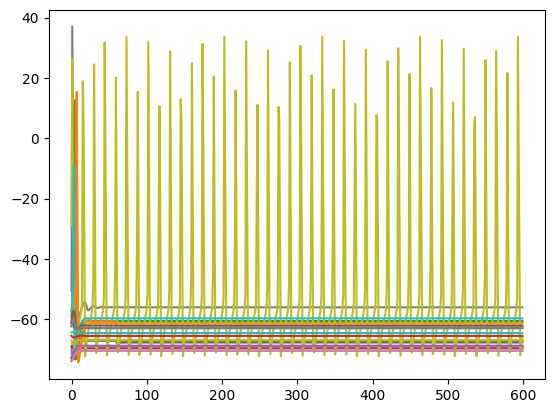

In [30]:
import matplotlib.pyplot as plt
t, v = H
t, v = np.array(t), np.array(v)
plt.plot(v)
#plt.imshow(v)
plt.show()

In [19]:
v.shape

(100, 20)

- нет четкого соответствия реализации в Neuron
- alpha синапсы вместо exp
- не тот маштаб времени **<- вот основная проблема** (скорее всего вызванно тем, что измеряем в разных еденицах, мне на 1000 приходится умножать)
- ~~не те потенциалы покоя, в общем схожи, нижняя граница совпадает, но не верхняя у меня -55. (точно не из за alpha синапсов)~~
- не совпадают стимулы, я подаю ток в 70 мА и ничо не получаю, а должно получатся при 0.7